# slimwrap.py

This library, located in the slimwrap.py file, is meant to simplify common tasks that usually require a lot of repetitive code. Its main goals are:

- Making it easy to define SLiM models inside Jupyter notebooks, which helps with sharing analyses between collaborators.
- Allowing SLiM models to be run with different parameters while keeping boilerplate to a minimum.
- Cutting down on the boilerplate needed to pass numpy arrays into SLiM.

# TL;TR
This library exposes one class named `SLiMModel` and has a main method named `run` that returns the standard `subprocess.CompletedProcess`. 

In [1]:
from slimwrap import SLiMModel

source_code = """
initialize() {
    initializeMutationRate(MU);
    initializeMutationType("m1", 0.5, "f", 0.0);
    initializeGenomicElementType("g1", m1, 1.0);
    initializeGenomicElement(g1, 0, L);
    initializeRecombinationRate(RHO);
}
1 early() {
    sim.addSubpop("p1", POP);
}
RUNTIME late() { sim.outputFixedMutations(); }
"""
model = SLiMModel(model_code=source_code)
params = {"MU":1e-7, "RHO" : 1e-8, "L" : int(1e6), "POP" : 1000, "RUNTIME" : 1000}
res = model.run(seed = 1234, constants = params)
res.stdout

b'// Initial random seed:\n1234\n\n// RunInitializeCallbacks():\ninitializeMutationRate(1e-07);\ninitializeMutationType(1, 0.5, "f", 0);\ninitializeGenomicElementType(1, m1, 1);\ninitializeGenomicElement(g1, 0, 1000000);\ninitializeRecombinationRate(1e-08);\n\n// Starting run at tick <start>:\n1 \n\n#OUT: 1000 1000 F\nMutations:\n'

## Example 1: Sharing self-contained notebooks

`SLiMModel` instances can be created from either a string encoding the SLiM model or a filepath. In both cases, we execute the slim `check` subcommand to ensure the model’s syntactic correctness. The instance retains its own copy of the model, preventing any modifications to the file from affecting an existing instance. 

Reading the model from a file is particularly advantageous for large simulations and when using SLiMGUI. Additionally, we’ve defined a simple `_repr_html_` method, allowing the source code to be embedded within the Jupyter notebook for completeness when sharing a notebook with collaborators (or your future self). 

In [2]:
model = SLiMModel(model_source="example.slim")
model

## Example 2: multiple simulations with minimal boilerplate

It is often the case that we want to run many simulations with different parameters. The proposed interface makes it possible to run complex simulations with minimal boilerplate code.

The steps of this simulation are the following: 

1. Draw a random oscillating population size trajectory.
2. Run SLiM with tree-sequence recording and create a temporary tree sequence.
3. Analyze it with `tskit` to compute some statistic (here, Tajima's D).

First, we define a function that simulates a random Ne trajectory. 

In [3]:
import numpy as np
GENERATIONS = np.arange(0, 1000)
def simulate_ne(seed):
    rng = np.random.default_rng(seed)
    baseline_ne = rng.normal(10_000, 1000)
    oscillation_amplitude = rng.normal(2_000, 1000)
    cycle_frequency =rng.uniform(0.001, 0.003)
    phase_shifts = rng.uniform(0, 2 * np.pi)
    return (baseline_ne + oscillation_amplitude * np.sin(
        2 * np.pi * cycle_frequency * GENERATIONS + phase_shifts
    )).astype(int)

We can check that the function works as intended by simulating some random trajectories and visualizing the result. Having everything in one language minimizes duplicated code and accidental bugs. 

Text(0, 0.5, 'Effective population size (Nₑ)')

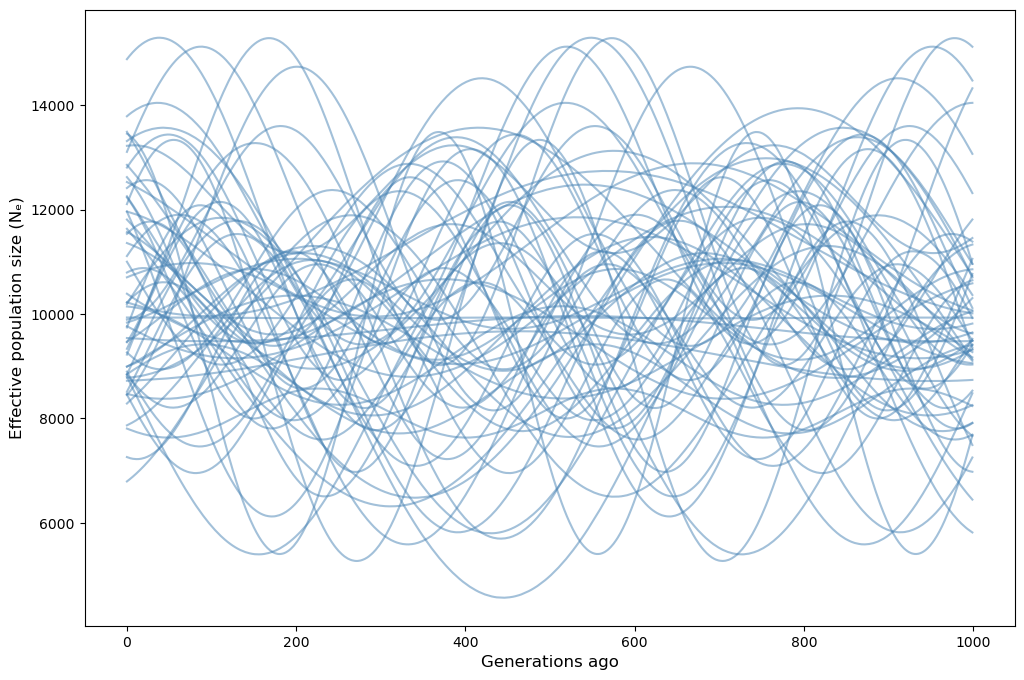

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
rng = np.random.default_rng(1234)
seeds = rng.integers(1, 2**32, 60)
for seed in seeds:
    ax.plot(GENERATIONS, simulate_ne(seed), alpha=0.5, color='steelblue')
ax.set_xlabel('Generations ago', fontsize=12)
ax.set_ylabel('Effective population size (Nₑ)', fontsize=12)

Next, we execute the simulations. We can use some widely used Python libraries to parallelize the computation across multiple cores and manage temporary files efficiently.

In [5]:
# Import python libraries
import tempfile, warnings
import multiprocess as mp
import tskit, pyslim, msprime
warnings.filterwarnings("ignore", module="pyslim")
warnings.simplefilter('ignore', msprime.TimeUnitsMismatchWarning)

# Define constant parameters
CONSTANT_PARAMETERS = {"L": int(1e7), "RHO": 1e-8, "MU": 1e-8}
 
def analysis(seed):
    # First, we draw a random Ne trajectory
    pop_sizes = simulate_ne(seed)
    # Create a temporary file for SLiM output
    with tempfile.NamedTemporaryFile(suffix=".trees") as file:
        model = SLiMModel(model_source="example.slim")
        params = {"OUTFILE": file.name, "POPSIZES": pop_sizes}
        # Run SLiM with combined constants and params
        model.run(seed=seed, constants={**CONSTANT_PARAMETERS, **params})
        # Load tree sequence from SLiM output
        ts = tskit.load(file.name)
    # Recapitate with pyslim
    rts = pyslim.recapitate(
        ts, ancestral_Ne=pop_sizes[-1],
        recombination_rate=CONSTANT_PARAMETERS["RHO"],
        random_seed=seed
    )
    # Add neutral mutations with msprime
    mts = msprime.sim_mutations(rts, rate=CONSTANT_PARAMETERS["MU"], random_seed=seed)
    # Compute and return Tajima's D
    return mts.Tajimas_D()

with mp.Pool(processes=8) as pool:
    statistics = pool.map(analysis, seeds)
np.mean(statistics), np.var(statistics)

(np.float64(-0.04473007669679723), np.float64(0.010723290698387728))

## Example 2: Passing 2D Arrays

The library also supports passing 2D NumPy arrays into SLiM as matrices. This feature is particularly useful when working with maps or dealing with multiple populations. For instance, I demonstrate how to simulate an autocorrelated landscape and load it into SLiM. This code relies on `scipy`, a comprehensive library for scientific computing. I find this approach more convenient (where external dependencies are called outside the SLiM script) compared to calling subprocesses within SLiM. 

In [6]:
from scipy.ndimage import gaussian_filter
# Simulate the autocorrelated environment
height, width = 20, 20
autocor_env = gaussian_filter(rng.random((height, width)), sigma=1.0, mode="reflect")

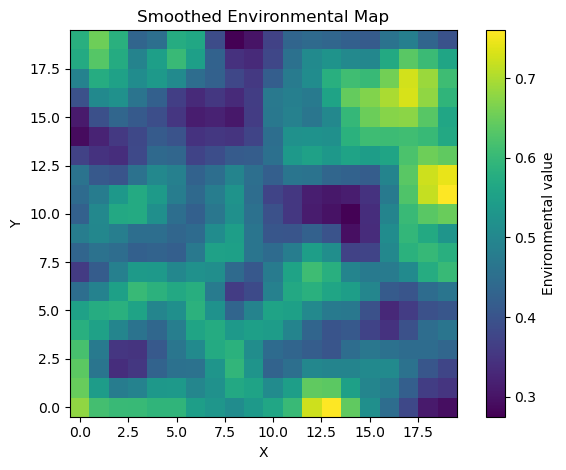

In [7]:
# Visualization
plt.imshow(autocor_env, cmap='viridis', origin='lower')
plt.colorbar(label='Environmental value')
plt.title("Smoothed Environmental Map")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

In [8]:
source_code = """
initialize() {
	initializeSLiMOptions(dimensionality="xy");
	initializeMutationRate(0.0);
	initializeMutationType("m1", 0.5, "f", 0.0);        // neutral
	initializeGenomicElementType("g1", m1, 1);
	initializeGenomicElement(g1, 0, 1e5);
	initializeRecombinationRate(1e-8);
}
1 late() {
	sim.addSubpop("p1", N);
	p1.setSpatialBounds(c(0.0, 0.0, HEIGHT, WIDTH));
	p1.individuals.setSpatialPosition(p1.pointUniform(N));
	map = p1.defineSpatialMap("map1", "xy", MAPVALUES);
	defineConstant("OPTIMUM", map);
}
"""
model = SLiMModel(model_code=source_code)
params = {
    "N" : 1000, "HEIGHT" : height,
    "WIDTH" : width, "MAPVALUES" : autocor_env
}
_ = model.run(constants=params)